
Running example of classification using GradientBoostedTrees

AUC 0.919

Running example of regression using GradientBoostedTrees

rmse 0.263
r2 0.678
mae 0.069


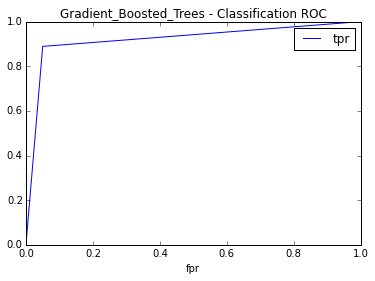

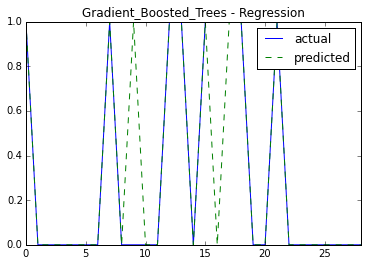

In [1]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from __future__ import print_function

import sys
import pandas

from pyspark import SparkContext
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import GBTRegressor
from pyspark.mllib.evaluation import BinaryClassificationMetrics, RegressionMetrics
from pyspark.mllib.util import MLUtils
from pyspark.sql import Row, SQLContext
from sklearn import metrics


def testClassification(train, test):
	# Train a GradientBoostedTrees model.
	rf = GBTClassifier(maxIter=30, maxDepth=4, labelCol="indexedLabel")
	model = rf.fit(train)
	predictionAndLabels = model.transform(test).select("prediction", "indexedLabel").map(lambda x: (x.prediction, x.indexedLabel))
	predictedDataFrame = sqlContext.createDataFrame(predictionAndLabels)
	

	# Creates data frame to plot ROC curve
	fpr, tpr, _ = metrics.roc_curve(predictedDataFrame.toPandas()['_1'].values, predictedDataFrame.toPandas()['_2'].values)
	
	
	df = pandas.DataFrame(dict(fpr=fpr, tpr=tpr))
	

	# ROC curve plot
	df.plot('fpr', 'tpr', title = 'Gradient_Boosted_Trees - Classification ROC')
	classificationMetrics = BinaryClassificationMetrics(predictionAndLabels)
	print("AUC %.3f" % classificationMetrics.areaUnderROC)


def testRegression(train, test):
	# Train a GradientBoostedTrees model.
	rf = GBTRegressor(maxIter=30, maxDepth=4, labelCol="indexedLabel")
	model = rf.fit(train)
	predictionAndLabels = model.transform(test).select("prediction", "indexedLabel").map(lambda x: (x.prediction, x.indexedLabel))
	predictedDataFrame = sqlContext.createDataFrame(predictionAndLabels)	
	# Created data frame for visualization
	df = predictedDataFrame.toPandas()
	df.columns = ['actual', 'predicted']	
	# 'Line' plot is used here to differentiate 'actual' and 'predicted' values
	df.plot(style=['-','--'], title = 'Gradient_Boosted_Trees - Regression')
	regressionMetrics = RegressionMetrics(predictionAndLabels)
	print("rmse %.3f" % regressionMetrics.rootMeanSquaredError)
	print("r2 %.3f" % regressionMetrics.r2)
	print("mae %.3f" % regressionMetrics.meanAbsoluteError)

# Initializes SQL context
sqlContext = SQLContext(sc)    

# Load and parse the data file into a dataframe.
df = MLUtils.loadLibSVMFile(sc, "/Data/Spark/MLLib/Sample_LibSVM_Data.txt").toDF()

# Map labels into an indexed column of labels in [0, numLabels)
stringIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
si_model = stringIndexer.fit(df)
td = si_model.transform(df)
[train, test] = td.randomSplit([0.7, 0.3])


print('\nRunning example of classification using GradientBoostedTrees\n')

testClassification(train, test)


print('\nRunning example of regression using GradientBoostedTrees\n')

testRegression(train, test)
